In [1]:
#include autoreload modules for fast testing and update
%load_ext autoreload
%autoreload 2

#import relevant modules
from entsoe import EntsoePandasClient, EntsoeRawClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import helpers modules
import sys
import os
import datetime

#set the time zone to make time filtering possible
import pytz

In [2]:
#import constants and configuration variables

sys.path.append('..')
from config import ENTSOE_API_TOKEN
from config import RAW_DATA_FOLDER

#import helper functions
from src.data.helper_epex import store_geographical_time_variables, store_data, process_xml_net_capacity

Here initiate the API client. The key is stored in the config file in the main folder.

In [3]:
client = EntsoePandasClient(api_key=ENTSOE_API_TOKEN)

### Introduction Downloading data

Here define the variables needed to download the data

In [16]:
#enter the date as year month day all attached
start_date='20200101'
end_date='20200703'
start, end, country_code_1, country_code_2= store_geographical_time_variables(start_date, 
                                                                              end_date,
                                                                              'Switzerland',
                                                                              'Germany')

Below there are an example of querying a quantity which is saved as series (crossborder flows) and one which is already returned as dataframe (load generation). Both of them are converted into Pandas Dataframes.

In [6]:
df_crossborder_flows=store_data(client.query_crossborder_flows(country_code_1, country_code_2, start=start, end=end), 'crossborder_flows')

In [7]:
df_crossborder_flows.head()

,crossborder_flows,time
0,0.0,2020-01-01 00:00:00+01:00
1,0.0,2020-01-01 01:00:00+01:00
2,0.0,2020-01-01 02:00:00+01:00
3,0.0,2020-01-01 03:00:00+01:00
4,0.0,2020-01-01 04:00:00+01:00


In [17]:
df_generation=store_data(client.query_generation(country_code=country_code_1, start=start, end=end))

In [18]:
df_generation.head()

,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Solar,Wind Onshore,time
0,149.0,176.0,737.0,2713.0,0.0,22.0,2020-01-01 00:00:00+01:00
1,179.0,170.0,668.0,2713.0,0.0,23.0,2020-01-01 01:00:00+01:00
2,180.0,176.0,689.0,2713.0,0.0,19.0,2020-01-01 02:00:00+01:00
3,81.0,170.0,642.0,2711.0,0.0,18.0,2020-01-01 03:00:00+01:00
4,97.0,168.0,596.0,2718.0,0.0,12.0,2020-01-01 04:00:00+01:00


With pandas you can quickly plot and have an high level view of the data in this manner.

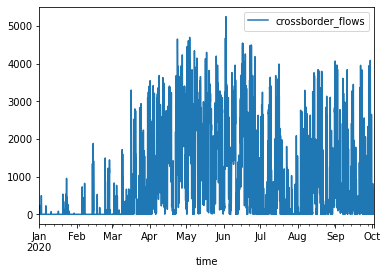

In [102]:
ax=df_crossborder_flows.plot(x='time', y='crossborder_flows')

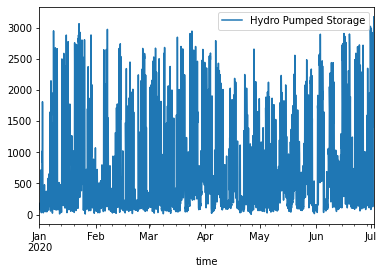

In [19]:
ax=df_generation.plot(x='time', y='Hydro Pumped Storage')

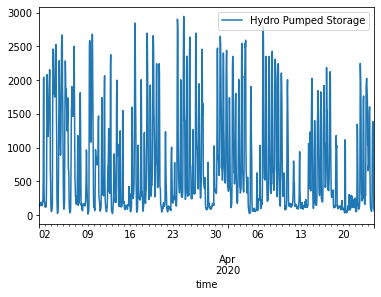

In [100]:
#filter time series indices by creating a mask of the necessary indices
mask=(df_generation['time']> datetime.datetime(2020,3,1, tzinfo=pytz.utc)) & (df_generation['time'] <= datetime.datetime(2020,4,25, tzinfo=pytz.utc))

#plot them
ax=df_generation[mask].plot(x='time', y='Hydro Pumped Storage')

### Exploration of Downloadable data

In [11]:
start_date='20200101'
end_date='20201025'
start, end, country_code_1, country_code_2= store_geographical_time_variables(start_date, 
                                                                              end_date,
                                                                              'Switzerland',
                                                                              'Germany')

##### CH DE cross border flows and Scheduled Exchanges

In [131]:
df_flow_CH_DE=store_data(client.query_crossborder_flows(country_code_1, country_code_2, start=start, end=end), 'crossborder_flow_CH_DE')
df_scheduled_exchanges_CH_DE=store_data(client.query_scheduled_exchanges(country_code_1, country_code_2, start=start, end=end), 'scheduled_exchanges_CH_DE')

In [132]:
df_flow_DE_CH=store_data(client.query_crossborder_flows(country_code_2, country_code_1, start=start, end=end), 'crossborder_flow_DE_CH')
df_scheduled_exchanges_DE_CH=store_data(client.query_scheduled_exchanges(country_code_2, country_code_1, start=start, end=end), 'scheduled_exchanges_DE_CH')

Join the dataframes

In [133]:
df_flows=pd.merge(pd.merge(df_flow_DE_CH,df_flow_CH_DE,on='time'),
                  pd.merge(df_scheduled_exchanges_CH_DE,df_scheduled_exchanges_DE_CH,on='time'),
                  on='time')

Comparison of the flos coming from Germany to Switzerland and vice versa

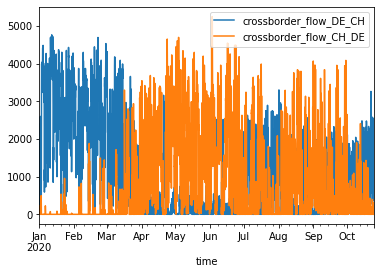

In [134]:
ax=df_flows.plot(x='time', y=['crossborder_flow_DE_CH',
                              'crossborder_flow_CH_DE'])

Comparison of scheduled exchanges with actual cross border flows

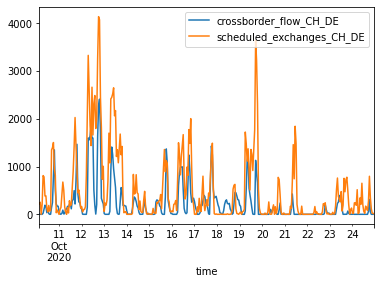

In [136]:
mask=(df_flows['time']> datetime.datetime(2020,10,10, tzinfo=pytz.utc)) & (df_flows['time'] <= datetime.datetime(2020,10,25, tzinfo=pytz.utc))

ax=df_flows[mask].plot(x='time', y=['crossborder_flow_CH_DE',
                              'scheduled_exchanges_CH_DE'])

##### Generation, Imports and Consumption and Hydro Capacity per Unit

In [132]:
df_generation_import=store_data(client.query_generation_import(country_code_1, start=start, end=end), 'generation_import')

NoMatchingDataError: between 2020-01-01 00:00:00+01:00 and 2020-03-03 00:00:00+01:00
NoMatchingDataError: between 2020-01-01 00:00:00+01:00 and 2020-03-03 00:00:00+01:00


In [133]:
df_generation_import.head()

Generation                                                        \
  Hydro Pumped Storage Hydro Run-of-river and poundage Hydro Water Reservoir   
0                149.0                           176.0                 737.0   
1                179.0                           170.0                 668.0   
2                180.0                           176.0                 689.0   
3                 81.0                           170.0                 642.0   
4                 97.0                           168.0                 596.0   

                             Import                         \
  Nuclear Solar Wind Onshore     AT   DE-LU     FR IT-NORD   
0  2713.0   0.0         22.0  724.0  1982.0  389.0     0.0   
1  2713.0   0.0         23.0  492.0  1589.0  727.0     0.0   
2  2713.0   0.0         19.0  437.0  1507.0  416.0     0.0   
3  2711.0   0.0         18.0  323.0  1591.0  714.0   183.0   
4  2718.0   0.0         12.0  139.0  1284.0  739.0   378.0   

                       time  
                             
0 2020-01-01 00:00:00+01:00  
1 2020-01-01 01:00:00+01:00  
2 2020-01-01 02:00:00+01:00  
3 2020-01-01 03:00:00+01:00  
4 2020-01-01 04:00:00+01:00

In [12]:
df_generation_per_plant=store_data(client.query_generation_per_plant(country_code_1, start=start, end=end), 'generation_per_plant')

Connection Error, retrying in 0 seconds


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
df_generation_per_plant.head()

In [54]:
df_generation_per_plant.head()

,AET Leventina,Amsteg,Bergell Turbinen,Beznau 1,Beznau 2,Centrale di Bavona,Centrale di Biasca,Centrale di Cavergno,Centrale di Olivone,Centrale di Robiei,...,Usine de Bieudron,Usine de Fionnay,Usine de Nant de Drance,Usine de Nendaz,Usine de Vallorcine,Usine de Veytaux,Usine de la BÃ¢tiaz,Verzasca,WÃ¤gital Turbinen,time
0,97.0,20.0,0.0,366.0,367.0,0.0,0.0,61.0,0.0,0.0,...,226.0,0.0,0.0,0.0,48.0,0.0,41.0,6.0,0.0,2020-01-01 00:00:00+01:00
1,101.0,15.0,0.0,365.0,367.0,0.0,0.0,7.0,0.0,0.0,...,261.0,0.0,0.0,0.0,49.0,0.0,41.0,0.0,0.0,2020-01-01 01:00:00+01:00
2,100.0,24.0,0.0,366.0,367.0,0.0,0.0,6.0,0.0,0.0,...,258.0,0.0,0.0,0.0,49.0,0.0,42.0,2.0,0.0,2020-01-01 02:00:00+01:00
3,87.0,22.0,0.0,365.0,367.0,0.0,0.0,8.0,0.0,0.0,...,236.0,0.0,0.0,0.0,49.0,0.0,41.0,15.0,0.0,2020-01-01 03:00:00+01:00
4,78.0,21.0,0.0,364.0,367.0,0.0,0.0,6.0,0.0,0.0,...,225.0,0.0,0.0,0.0,49.0,0.0,41.0,22.0,0.0,2020-01-01 04:00:00+01:00


The unused capacity per palnt at every hour can be computed by knowing the capacity per unit of the plants.

In [60]:
df_capacity_per_plant=client.query_installed_generation_capacity_per_unit(country_code=country_code_1, start=start, end=end)

In [61]:
df_capacity_per_plant

,Bidding Zone,Installed Capacity [MW],Name,Production Type,Voltage Connection Level [kV]
12W-0000000797-L,10YCH-SWISSGRIDZ,126,Kraftwerk LÃ¶tschen,Hydro Run-of-river and poundage,65
12W-0000000018-B,10YCH-SWISSGRIDZ,1524,KLL - KW Linth-Limmern AG,Hydro Pumped Storage,380
12W-0000000011-W,10YCH-SWISSGRIDZ,258,KWZ - KW Zervreila AG,Hydro Water Reservoir,220
12W-0000000021-S,10YCH-SWISSGRIDZ,336,KVR - KW Vorderrhein AG,Hydro Water Reservoir,220
12W-0000000065-0,10YCH-SWISSGRIDZ,114,Verzasca,Hydro Water Reservoir,150
12W-0000000052-D,10YCH-SWISSGRIDZ,1220,KKL - KernKW Leibstadt AG,Nuclear,380
12W-0000000105-J,10YCH-SWISSGRIDZ,340,Electra-Massa (EM),Hydro Water Reservoir,220
12W-0000000016-H,10YCH-SWISSGRIDZ,640,KHR - KW Hinterrhein AG,Hydro Pumped Storage,220
12W-0000000034-F,10YCH-SWISSGRIDZ,421,Kraftwerke Mauvoisin AG,Hydro Water Reservoir,220
12W-0000000017-E,10YCH-SWISSGRIDZ,730,KKB - KernKW Beznau,Nuclear,380


##### Transfer capacity

Problems in identifying the explicit capacity allocation (transfer capacity): 

1) It is not possible to look back in time more than 2 months with the API

2) The explicit auction for the intraday cross-border capacity between Germany and Switzerland are not loaded through API. It seems like Germany doesn't load both with python API and with the direct API request.

3) What is the difference between Control Zone, Bidding Zone and Bidding Zone Aggregation in [here](https://transparency.entsoe.eu/transmission/r2/explicitAllocationsIntraday/show?name=&defaultValue=false&viewType=TABLE&areaType=BORDER_CTA&atch=false&dateTime.dateTime=08.10.2020+00:00|UTC|DAY&dateTime.endDateTime=14.10.2020+00:00|UTC|DAY&border.values=CTY|10YCH-SWISSGRIDZ!CTA_CTA|10YCH-SWISSGRIDZ_CTA_CTA|10YIT-GRTN-----B&direction.values=Export&direction.values=Import&category.values=A01&category.values=A04&category.values=A03&category.values=A02&sequence.values=1&sequence.values=2&sequence.values=3&sequence.values=4&sequence.values=5&sequence.values=6&dv-datatable_length=10)?

4) For the intraday capacity allocation, those of Transnet and Amprion are seperated so we should sum them up right?

5) OC, RC and AC different categories: what is the meaning?

In [40]:
start_date='20200901'
end_date='20201015'
start, end, country_code_1, country_code_2= store_geographical_time_variables(start_date, 
                                                                              end_date,
                                                                              'Switzerland',
                                                                              'Austria')

In [43]:
df_net_transfer_capacity_dayahead_CH_AT=process_xml_net_capacity(client.query_net_transfer_capacity_dayahead(country_code_from=country_code_1,
                                                                     country_code_to=country_code_2,
                                                                     start=start, end=end), 
                         start, 
                         end,
                         name='net_transfer_capacity_dayahead_CH_AT')

In [44]:
df_net_transfer_capacity_dayahead_CH_AT

,time,net_transfer_capacity_dayahead_CH_AT
0,2020-09-01 00:00,1200
1,2020-09-01 01:00,1200
2,2020-09-01 02:00,1200
3,2020-09-01 03:00,1200
4,2020-09-01 04:00,1200
...,...,...
1051,2020-10-14 19:00,1200
1052,2020-10-14 20:00,1200
1053,2020-10-14 21:00,1200
1054,2020-10-14 22:00,1200


As it can be seen the results of this query method return the same results which can be found on the ENTSOE website with a [search](https://transparency.entsoe.eu/transmission/r2/explicitAllocationsIntraday/show?name=&defaultValue=false&viewType=TABLE&areaType=BORDER_CTA&atch=false&dateTime.dateTime=08.10.2020+00:00|UTC|DAY&dateTime.endDateTime=14.10.2020+00:00|UTC|DAY&border.values=CTY|10YCH-SWISSGRIDZ!CTA_CTA|10YCH-SWISSGRIDZ_CTA_CTA|10YAT-APG------L&direction.values=Export&direction.values=Import&category.values=A01&category.values=A04&category.values=A03&category.values=A02&sequence.values=1&sequence.values=2&sequence.values=3&sequence.values=4&sequence.values=5&sequence.values=6&dv-datatable_length=10) and the results obtained directly the API with the following GET method call: 

[GET CALL](https://transparency.entsoe.eu/api?securityToken=df864219-29a3-4e62-977a-f94967ea1ec4&documentType=A25&businessType=B05&contract_MarketAgreement.Type=A01&in_Domain=10YCH-SWISSGRIDZ&out_Domain=10YAT-APG------L&auction.Category=A01&classificationSequence_AttributeInstanceComponent.Position=1&periodStart=202009012300&periodEnd=202010152300)

It should be noticed that using the raw API get method call also the prices of the capacities are shown.

Unable to get German data automatically

In [9]:
start_date='20201029'
end_date='20201031'
start, end, country_code_1, country_code_2= store_geographical_time_variables(start_date, 
                                                                              end_date,
                                                                              'Germany',
                                                                              'Switzerland')

In [11]:
df_net_transfer_capacity_dayahead_CH_DE=process_xml_net_capacity(client.query_net_transfer_capacity_dayahead(country_code_from=country_code_1,
                                                                     country_code_to=country_code_2,
                                                                     start=start, end=end), 
                         start, 
                         end,
                         name='net_transfer_capacity_dayahead_CH_DE')

HTTPError: 400 Client Error: Bad Request for url: https://transparency.entsoe.eu/api?documentType=A61&in_Domain=10YCH-SWISSGRIDZ&out_Domain=10Y1001A1001A83F&contract_MarketAgreement.Type=A01&securityToken=df864219-29a3-4e62-977a-f94967ea1ec4&periodStart=202010282300&periodEnd=202010302300

## Draft Work

With methods that return series some more work is required.

In [ ]:
# methods that return Pandas Series
day_ahead_prices=client.query_day_ahead_prices(country_code, start=start,end=end)
load=client.query_load(country_code, start=start,end=end)
load_forecast=client.query_load_forecast(country_code, start=start,end=end)
generation_forecast=client.query_generation_forecast(country_code, start=start,end=end)

In [30]:
day_ahead_prices=client.query_day_ahead_prices(country_code, start=start,end=end)

In [31]:
day_ahead_prices_df=pd.DataFrame({'day_ahead_price':day_ahead_prices})

<AxesSubplot:>

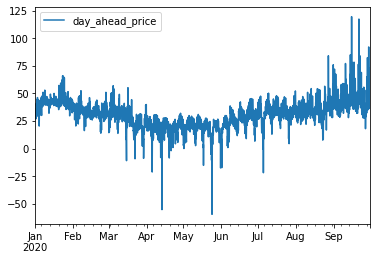

In [32]:
day_ahead_prices_df.plot()

In [56]:
crossborder_flows=client.query_crossborder_flows('CH', 'DE', start=start,end=end)

In [60]:
type(crossborder_flows)==pd.core.series.Series

True

In [38]:
crossborder_flows_df=pd.DataFrame({'crossborder_flows':crossborder_flows})

<AxesSubplot:>

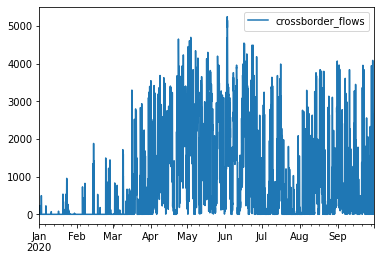

In [39]:
crossborder_flows_df.plot()

Methods returning dataframe can be easily used. The only problem is the units. More research needed to find what are the standard units when the query is done.

In [52]:
start_date='20200901'
end_date='20201001'

In [54]:
start = pd.Timestamp(start_date, tz='Europe/Brussels')
end = pd.Timestamp(end_date, tz='Europe/Brussels')
country_code = 'CH'  # Switzerland

In [55]:
wind_and_solar_forecast_df=client.query_wind_and_solar_forecast(country_code=country_code, start=start, end=end)

<AxesSubplot:>

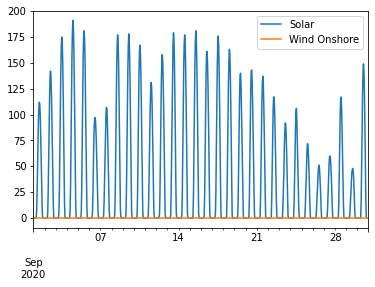

In [57]:
wind_and_solar_forecast_df.plot()

In [ ]:
generation_df=client.query_generation(country_code='GB', start=start, end=end)

In [59]:
generation_df.head()

,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Solar,Wind Onshore
2020-09-01 00:00:00+02:00,426.0,232.0,1300.0,2954.0,0.0,3.0
2020-09-01 01:00:00+02:00,306.0,202.0,1030.0,2957.0,0.0,0.0
2020-09-01 02:00:00+02:00,227.0,194.0,869.0,2958.0,0.0,0.0
2020-09-01 03:00:00+02:00,93.0,208.0,957.0,2958.0,0.0,0.0
2020-09-01 04:00:00+02:00,139.0,216.0,869.0,2959.0,0.0,0.0


In [42]:
installed_generation_capacity_df=client.query_installed_generation_capacity(country_code='IT_SACO_AC', 
                                                                            start=pd.Timestamp('20190901', tz='Europe/Brussels'),
                                                                            end=pd.Timestamp('20200901', tz='Europe/Brussels'))

KeyError: 'IT_SACO_AC'

In [41]:
installed_generation_capacity_df.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
2020-01-01 00:00:00+01:00,7987.0,21067.0,0.0,31712.0,22458.0,4373.0,47.0,9422.0,3970.0,1298.0,8114.0,1558.0,407.0,48206.0,1661.0,7504.0,53184.0


In [76]:
installed_generation_capacity_per_unit_df=client.query_installed_generation_capacity_per_unit(country_code='CH', 
                                                                                             start=pd.Timestamp('20190901', tz='Europe/Brussels'),
                                                                                             end=pd.Timestamp('20200901', tz='Europe/Brussels'))

In [77]:
installed_generation_capacity_per_unit_df

,Bidding Zone,Installed Capacity [MW],Name,Production Type,Voltage Connection Level [kV]
12W-0000000797-L,10YCH-SWISSGRIDZ,126,Kraftwerk LÃ¶tschen,Hydro Run-of-river and poundage,65
12W-0000000018-B,10YCH-SWISSGRIDZ,1524,KLL - KW Linth-Limmern AG,Hydro Pumped Storage,380
12W-0000000011-W,10YCH-SWISSGRIDZ,258,KWZ - KW Zervreila AG,Hydro Water Reservoir,220
12W-0000000021-S,10YCH-SWISSGRIDZ,336,KVR - KW Vorderrhein AG,Hydro Water Reservoir,220
12W-0000000065-0,10YCH-SWISSGRIDZ,114,Verzasca,Hydro Water Reservoir,150
12W-0000000052-D,10YCH-SWISSGRIDZ,1220,KKL - KernKW Leibstadt AG,Nuclear,380
12W-0000000105-J,10YCH-SWISSGRIDZ,340,Electra-Massa (EM),Hydro Water Reservoir,220
12W-0000000016-H,10YCH-SWISSGRIDZ,640,KHR - KW Hinterrhein AG,Hydro Pumped Storage,220
12W-0000000034-F,10YCH-SWISSGRIDZ,421,Kraftwerke Mauvoisin AG,Hydro Water Reservoir,220
12W-0000000017-E,10YCH-SWISSGRIDZ,730,KKB - KernKW Beznau,Nuclear,380


For other implementable data download and visualizations possibilities look here: https://github.com/EnergieID/entsoe-py/blob/master/Demo.ipynb

In [ ]:


# methods that return Pandas DataFrames
wind_and_solar_forecast=client.query_wind_and_solar_forecast(country_code, start=start,end=end, psr_type=None)
generation=client.query_generation(country_code, start=start,end=end, psr_type=None)
installed_generation_capacity=client.query_installed_generation_capacity(country_code, start=start,end=end, psr_type=None)
crossborder_flows=client.query_crossborder_flows('DE', 'SI', start=start,end=end)
imbalance_prices=client.query_imbalance_prices(country_code, start=start,end=end, psr_type=None)
unavailability_of_generation_units=client.query_unavailability_of_generation_units(country_code, start=start,end=end, docstatus=None)
withdrawn_unavailability_of_generation_units=client.query_withdrawn_unavailability_of_generation_units('DE', start=start,end=end)

Dumping files in data folder

In [ ]:
dictionary_naming={'day_ahead_prices':day_ahead_prices,
                  }
#check if directory exists

#make directory named with  start_date and end_date
# folder=os.m

#loop to dump the data
for key, value in zip(dictionary_naming.keys(), dictionary_naming.values()):
    
    value.to_csv(RAW_DATA_FOLDER+key+'.csv')